In [3]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import torch

%load_ext autoreload
%autoreload 2

import sys 
sys.path.append('..')
from models import DIFDensityEstimator, MixedModelDensityEstimator, RealNVPDensityEstimatorLayer, MultivariateNormalReference
from utils.color_visual import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(225, 225, 4)


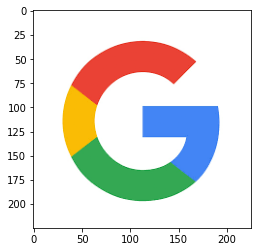

In [4]:
rgb = image.imread("Google.png")
plt.imshow(rgb)
print(rgb.shape)

(225, 225)


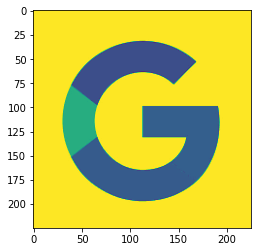

In [5]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = rgb2gray(rgb)
#plt.imshow(grey)
print(grey.shape)
plt.imshow(torch.tensor(grey)/torch.sum(torch.tensor(grey)))

In [6]:
vector_density = torch.tensor(grey.flatten())
vector_density =vector_density/torch.sum(vector_density)

In [12]:
l, L = grey.shape
num_samples = 10000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
samples = torch.cat([(categorical_samples//L).unsqueeze(-1), (categorical_samples%L).unsqueeze(-1)], dim = -1) + 0.1*torch.randn([num_samples,2])

<ipython-input-12-0fd8ce246440>:5: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  samples = torch.cat([(categorical_samples//L).unsqueeze(-1), (categorical_samples%L).unsqueeze(-1)], dim = -1) + 0.1*torch.randn([num_samples,2])


In [13]:
print(samples.shape)

torch.Size([10000, 2])


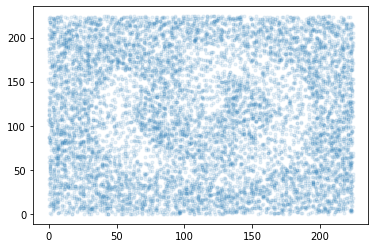

In [14]:
plt.scatter(samples[:,0], samples[:, 1], alpha = .1, marker = '.')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.73it/s, loss = 11.263077735900879]


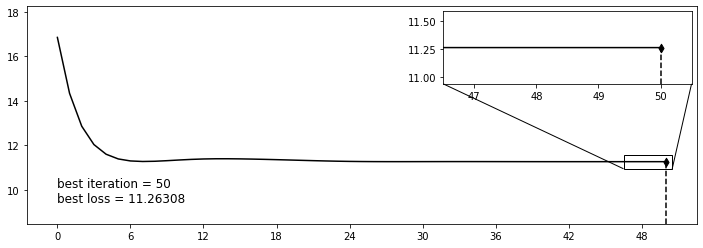

In [15]:
structure = [[RealNVPDensityEstimatorLayer,[128,128]],[RealNVPDensityEstimatorLayer,[128,128]],[RealNVPDensityEstimatorLayer,[128,128]]]
reference = MultivariateNormalReference(2)
reference.estimate_moments(samples.float())
dif = MixedModelDensityEstimator(samples.float(),structure,initial_reference = reference)
loss_values = dif.train(50,5000,visual = True)

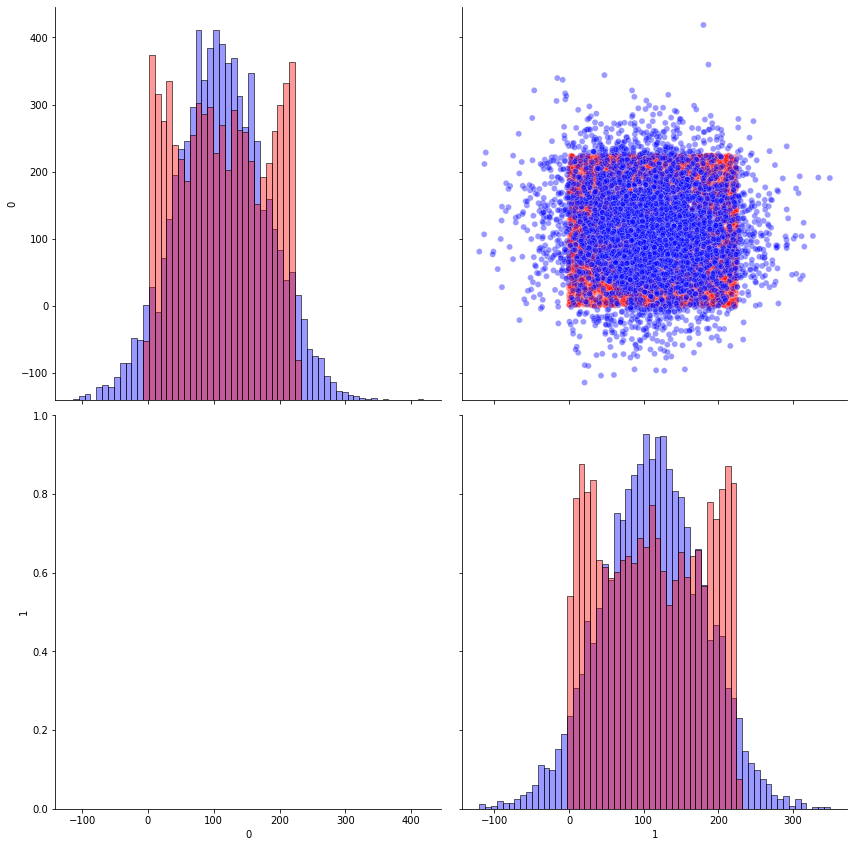

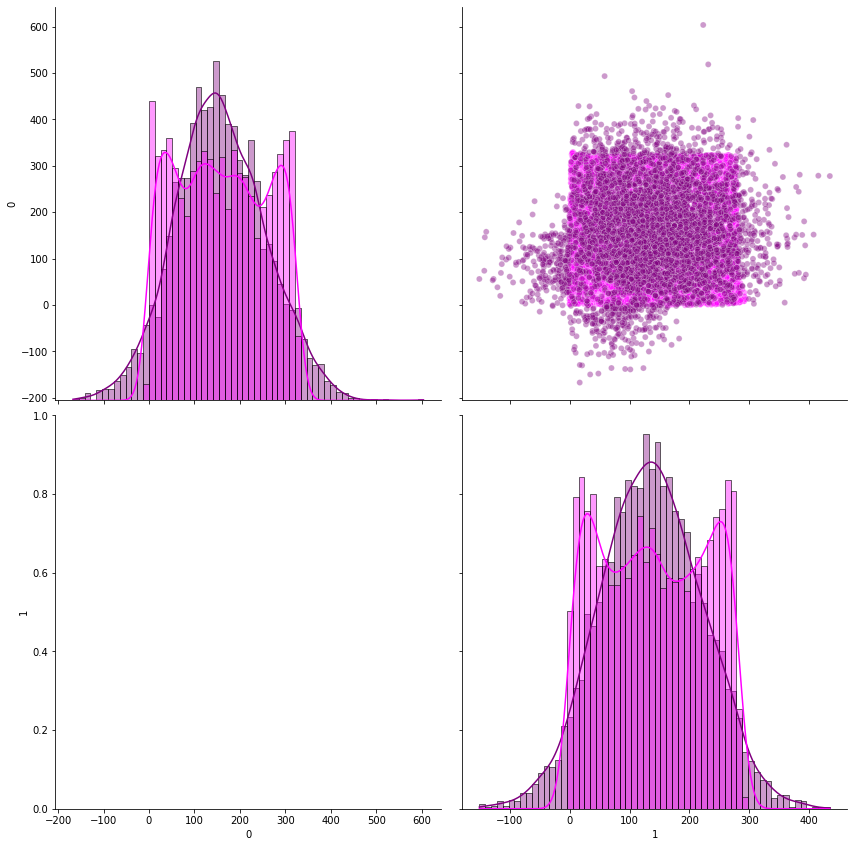

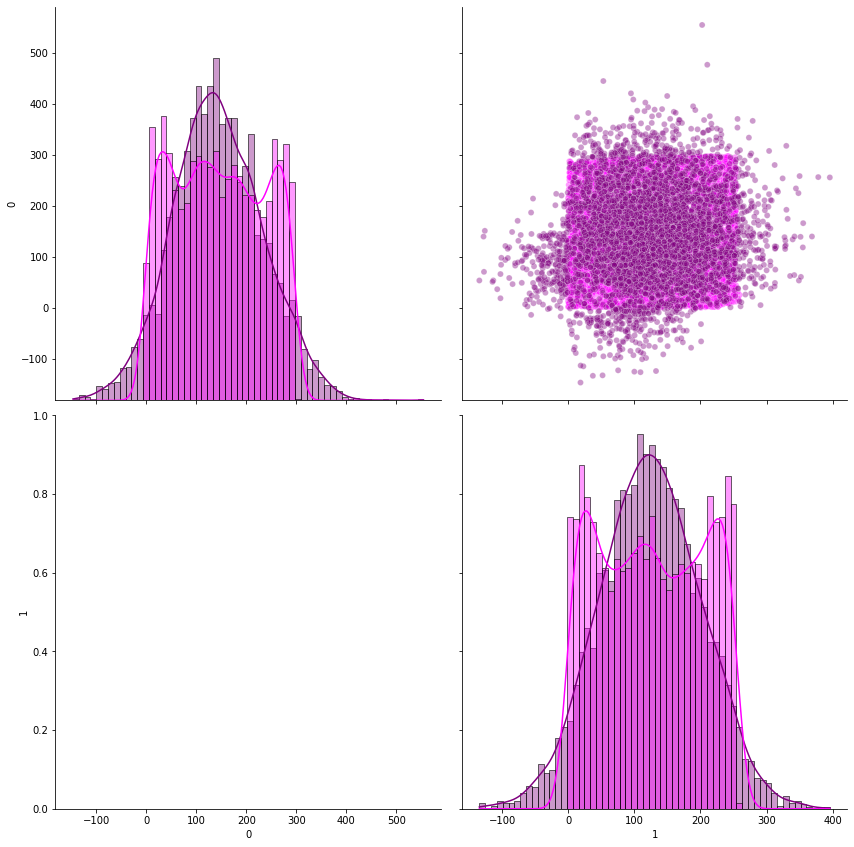

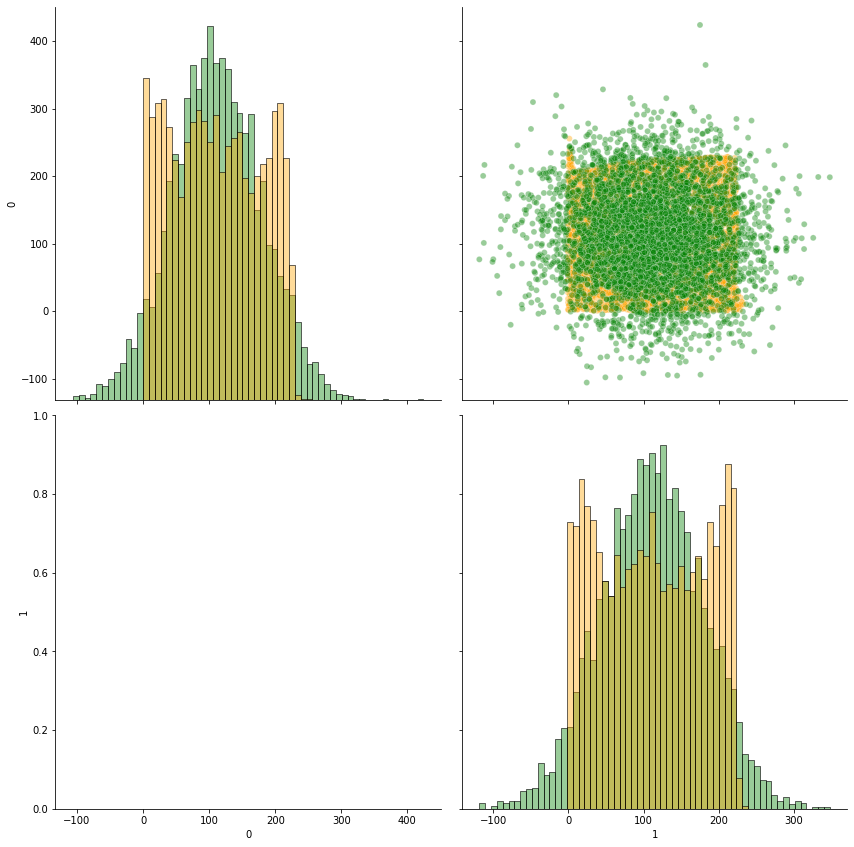

In [16]:
dif.model_visual()

torch.Size([40000, 2])


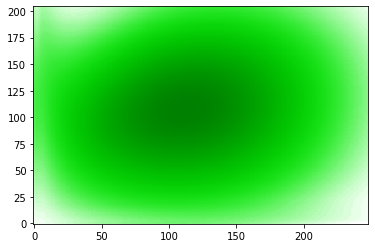

In [78]:
delta = 200
grid = torch.cartesian_prod(torch.linspace(0, l,delta),torch.linspace(0, L, delta))
print(grid.shape)
density = torch.exp(dif.log_density(grid)).reshape(delta,delta).T.cpu().detach()
plt.pcolormesh(torch.linspace(0, l,delta),torch.linspace(0, L,delta), density, cmap=green_cmap,shading='auto')